Dataset Shape: (1599, 12)

Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First few rows:
Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   fl

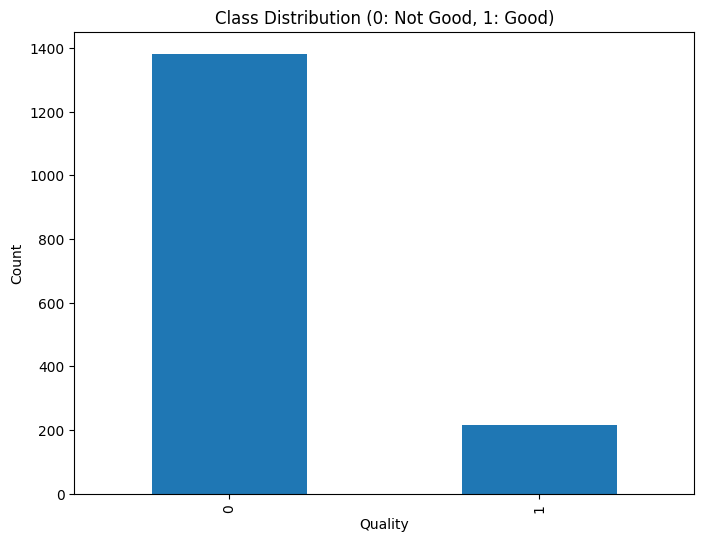

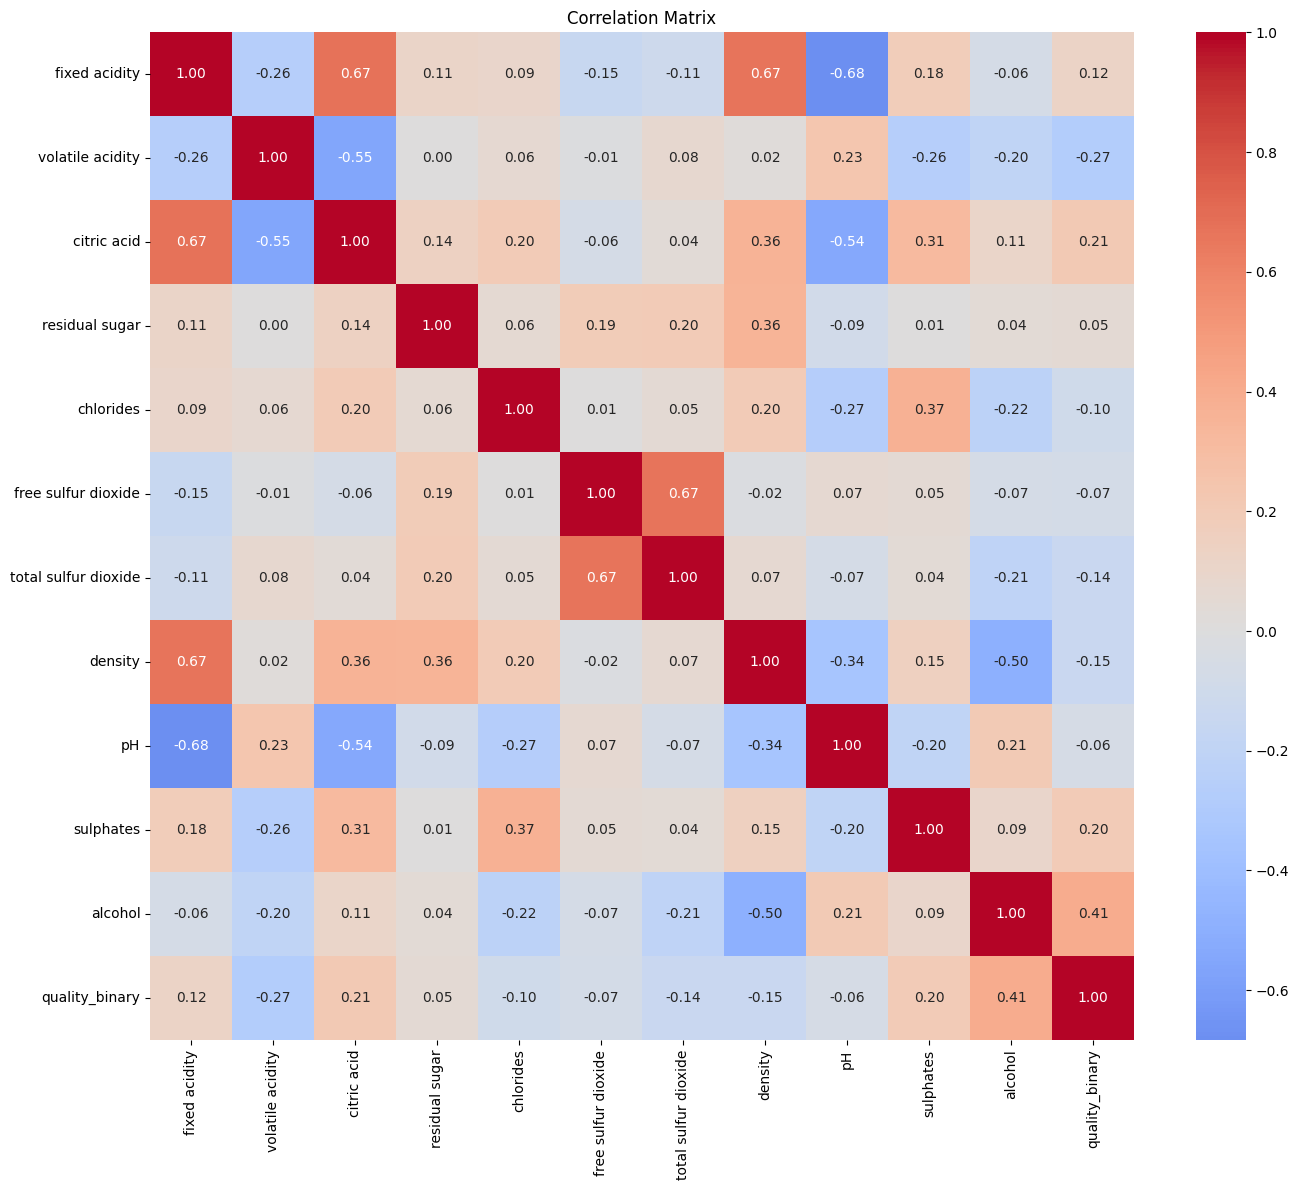

Features shape: (1599, 11)
Target shape: (1599,)
Training set size: (1279, 11)
Test set size: (320, 11)
Logistic Regression Results: {'Model': 'Logistic Regression', 'Accuracy': 0.8938, 'AUC': 0.8804, 'Precision': 0.6957, 'Recall': 0.3721, 'F1': 0.4848, 'MCC': 0.458}
Decision Tree Results: {'Model': 'Decision Tree', 'Accuracy': 0.9, 'AUC': 0.8389, 'Precision': 0.6122, 'Recall': 0.6977, 'F1': 0.6522, 'MCC': 0.5958}
KNN Results: {'Model': 'KNN', 'Accuracy': 0.8938, 'AUC': 0.8237, 'Precision': 0.6667, 'Recall': 0.4186, 'F1': 0.5143, 'MCC': 0.4738}
Naive Bayes Results: {'Model': 'Naive Bayes', 'Accuracy': 0.8594, 'AUC': 0.8517, 'Precision': 0.4844, 'Recall': 0.7209, 'F1': 0.5794, 'MCC': 0.5131}
Random Forest Results: {'Model': 'Random Forest', 'Accuracy': 0.9375, 'AUC': 0.9549, 'Precision': 0.9259, 'Recall': 0.5814, 'F1': 0.7143, 'MCC': 0.7045}
XGBoost Results: {'Model': 'XGBoost', 'Accuracy': 0.9406, 'AUC': 0.9422, 'Precision': 0.875, 'Recall': 0.6512, 'F1': 0.7467, 'MCC': 0.7239}

=== Mo

<Figure size 1400x800 with 0 Axes>

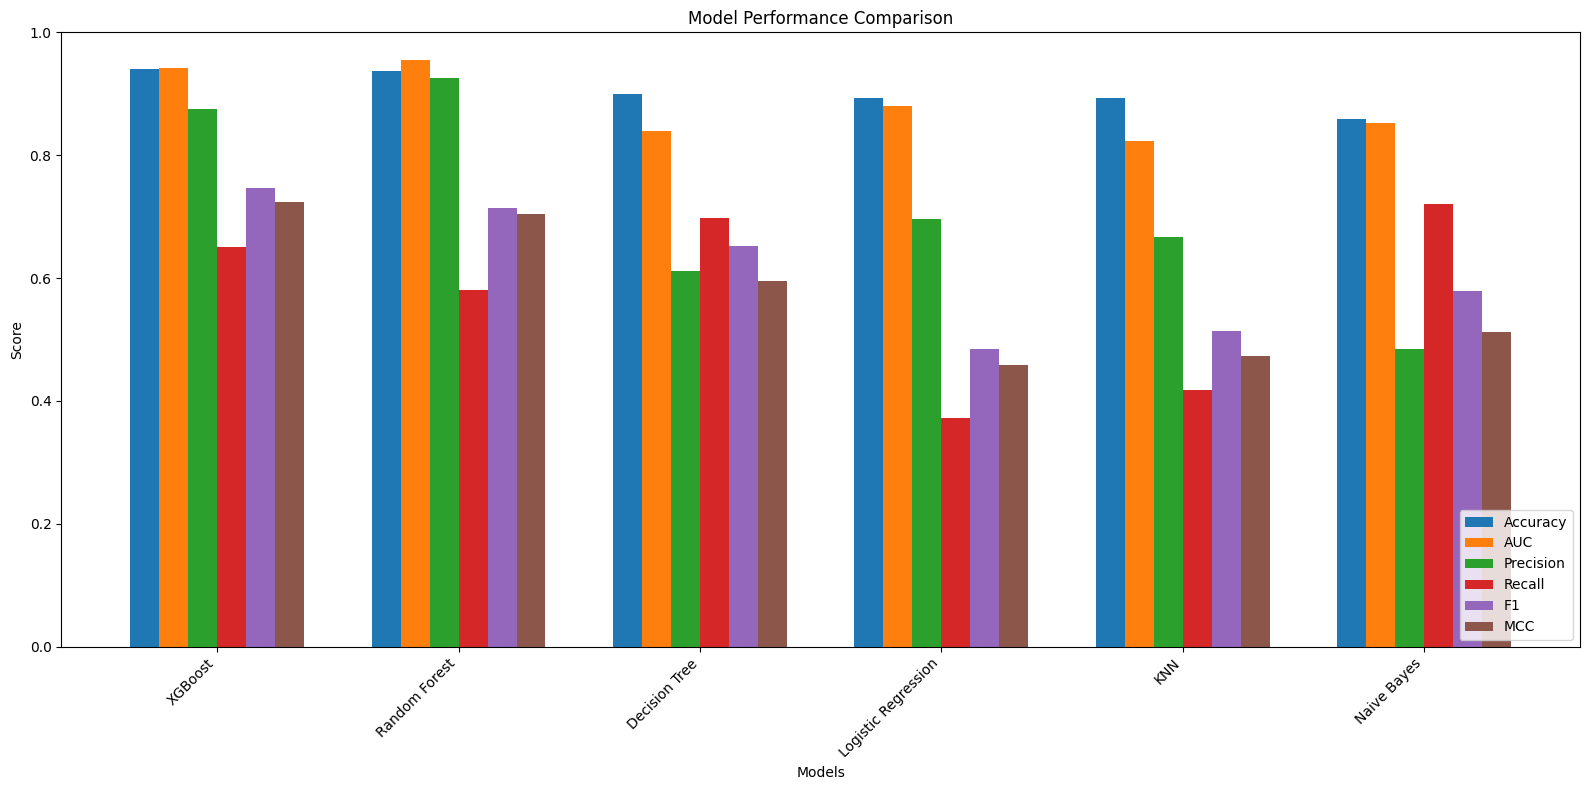

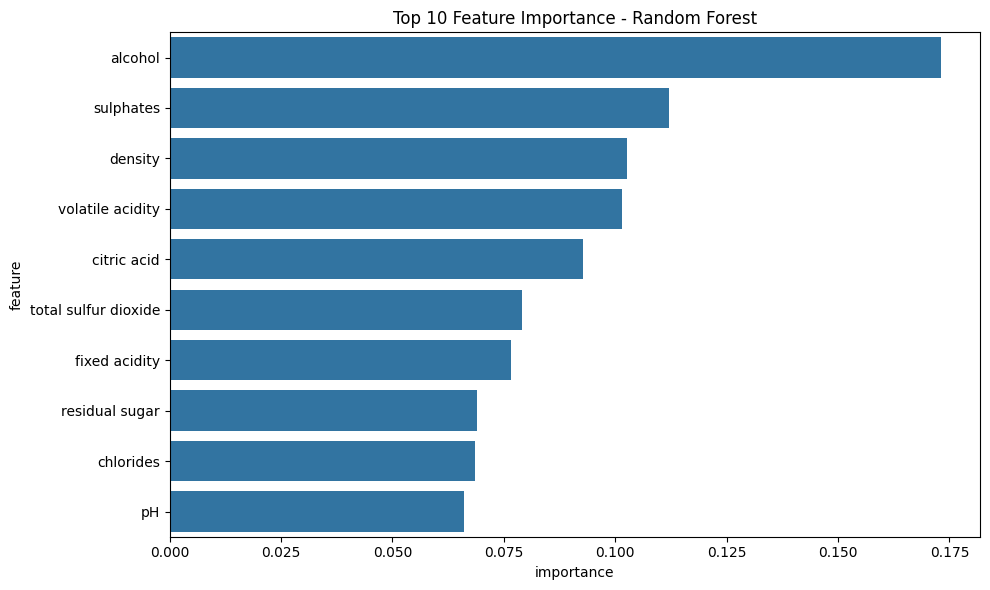

All models trained and saved successfully!


In [1]:

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, matthews_corrcoef, 
                           confusion_matrix, classification_report)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import joblib
import os

# Create model directory if it doesn't exist
if not os.path.exists('model'):
    os.makedirs('model')

# %% [markdown]
# ### Load and Explore Dataset

# %%
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

print("Dataset Shape:", df.shape)
print("\nFeatures:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

# %%
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# %%
# Dataset info
print("\nDataset Info:")
df.info()

# %%
# Statistical summary
print("\nStatistical Summary:")
df.describe()

# %%
# Convert to binary classification (quality >= 7 = good wine)
df['quality_binary'] = (df['quality'] >= 7).astype(int)
df['quality_binary'].value_counts()

# %%
# Visualize class distribution
plt.figure(figsize=(8, 6))
df['quality_binary'].value_counts().plot(kind='bar')
plt.title('Class Distribution (0: Not Good, 1: Good)')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.savefig('model/class_distribution.png')
plt.show()

# %%
# Correlation matrix
plt.figure(figsize=(14, 12))
correlation_matrix = df.drop('quality', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('model/correlation_matrix.png')
plt.show()

# %% [markdown]
# ### Prepare Data for Modeling

# %%
# Separate features and target
X = df.drop(['quality', 'quality_binary'], axis=1)
y = df['quality_binary']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# %%
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# %%
# Scale features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'C:/Users/arpit/Desktop/BITS_PILANI/SEM 2/MACHINE LEARNING/assignment-2/model/scaler.pkl')

# %% [markdown]
# ### Model Training and Evaluation Function

# %%
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, scaled=False):
    """
    Train and evaluate a model, return metrics
    """
    # Train the model
    if scaled:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Save model
    joblib.dump(model, f'C:/Users/arpit/Desktop/BITS_PILANI/SEM 2/MACHINE LEARNING/assignment-2/model/{model_name.lower().replace(" ", "_")}.pkl')
    
    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'C:/Users/arpit/Desktop/BITS_PILANI/SEM 2/MACHINE LEARNING/assignment-2/model/cm_{model_name.lower().replace(" ", "_")}.png')
    plt.close()
    
    return {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'AUC': round(auc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4),
        'MCC': round(mcc, 4)
    }

# %% [markdown]
# ### 1. Logistic Regression

# %%
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg_results = evaluate_model(log_reg, X_train_scaled, X_test_scaled, 
                                y_train, y_test, "Logistic Regression", scaled=True)
print("Logistic Regression Results:", log_reg_results)

# %% [markdown]
# ### 2. Decision Tree Classifier

# %%
dt = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_results = evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")
print("Decision Tree Results:", dt_results)

# %% [markdown]
# ### 3. K-Nearest Neighbors Classifier

# %%
knn = KNeighborsClassifier(n_neighbors=5)
knn_results = evaluate_model(knn, X_train_scaled, X_test_scaled, 
                            y_train, y_test, "KNN", scaled=True)
print("KNN Results:", knn_results)

# %% [markdown]
# ### 4. Naive Bayes Classifier

# %%
nb = GaussianNB()
nb_results = evaluate_model(nb, X_train_scaled, X_test_scaled, 
                           y_train, y_test, "Naive Bayes", scaled=True)
print("Naive Bayes Results:", nb_results)

# %% [markdown]
# ### 5. Random Forest (Ensemble)

# %%
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15)
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
print("Random Forest Results:", rf_results)

# %% [markdown]
# ### 6. XGBoost (Ensemble)

# %%
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, 
                             eval_metric='logloss')
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
print("XGBoost Results:", xgb_results)

# %% [markdown]
# ### Compare All Models

# %%
# Create comparison dataframe
results_df = pd.DataFrame([
    log_reg_results,
    dt_results,
    knn_results,
    nb_results,
    rf_results,
    xgb_results
])

# Sort by accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)
print("\n=== Model Performance Comparison ===")
results_df

# %%
# Save results to CSV
results_df.to_csv('C:/Users/arpit/Desktop/BITS_PILANI/SEM 2/MACHINE LEARNING/assignment-2/model/model_comparison.csv', index=False)

# %%
# Visualize model comparison
plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']
x = np.arange(len(results_df['Model']))
width = 0.12

fig, ax = plt.subplots(figsize=(16, 8))
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, results_df[metric], width, label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# %%
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

print("All models trained and saved successfully!")